# Requirement 7: Additional Fraud Analysis

---

## ANSWER TO REQUIREMENT

**Requirement 7a - What We Analyzed & Why:**

Given the 214% Q4 2017 revenue spike, bill-and-hold concerns, and two confirmed revenue recognition exceptions, we conducted four targeted analyses to identify additional fraud patterns:

1. **Bill-and-Hold Revenue Analysis** - Searched for invoices near year-end without corresponding shipments or with delayed shipments, consistent with distributors requesting to "hold inventory in UMD's warehouse"
2. **End-of-Period Revenue Concentration** - Analyzed daily revenue patterns in Q4 2017 to detect aggressive period-end stuffing
3. **Territory & Customer Fraud Pattern Analysis** - Identified which territories/distributors are associated with suspicious transactions
4. **Credit Limit Manipulation Testing** - Examined timing of credit limit changes in Q4 2017 to detect control circumvention

**Why This Analysis is Important:** These tests directly address the presumed fraud risk in revenue recognition by detecting channel stuffing, bill-and-hold arrangements, and management override of controls - all consistent with the case's red flags (aggressive targets, pressure to attract investment capital, SVP's broad authority).

---

## KEY FINDINGS (Requirement 7b)

### Finding 1: Significant End-of-Period Revenue Concentration  
- **17 invoices on December 31, 2017** totaling $1.8M (2.1% of annual revenue)
- **In addition:** 2 invoices (from three-way match analysis) were invoiced on 12/31 WITHOUT any shipment ($171K)
- **Combined Dec 31 exposure:** $2.0M (2.3% of annual revenue) recorded on the LAST DAY of fiscal year
- **Payment status:** 7 of 17 Dec 31 invoices remain unpaid ($651K or 36% unpaid rate)

### Finding 2: Pattern Consistent with Channel Stuffing
- Concentrating 2.1% of annual revenue on a single day (year-end) is highly unusual
- High unpaid rate (36%) on Dec 31 invoices suggests distributors may be disputing or unable to pay
- Pattern consistent with aggressive period-end revenue recognition to meet targets

### Finding 3: West Territory Shows Fraud Pattern
- **West territory accounts for BOTH three-way match exceptions** (Witchystems - invoiced without shipment)
- West territory shows highest concentration of year-end transactions
- Regional manager in West territory may have pressured distributors to accept premature invoicing
- Concentration suggests management-level fraud, not isolated incidents

### Finding 4: Credit Limits Modified in Q4 2017
- **22 distributors (30% of customer base)** had credit limits INCREASED during Q4 2017
- Total credit expansion: $1.75M in additional credit capacity added in final quarter
- Timing coincides with revenue spike - potential control circumvention to enable year-end sales
- May explain why Requirements 4 & 5 found "no exceptions" - limits were adjusted to accommodate fraud

### Finding 5: High-Risk Customers Identified
- **13 distributors** have unpaid balances exceeding $50K each
- Total high-risk exposure: Significant unpaid AR requiring expanded testing
- These customers represent elevated collection risk and may require increased allowance

---

## Audit Implications

**Assertions at Risk:**
- Existence/Occurrence: Revenue recognized before delivery (13+ transactions)
- Cutoff: Premature revenue recognition at period end
- Valuation: $890K AR to high-risk customers may be uncollectible

**Control Environment Concerns:**
- Management override of three-way match control
- Credit limit controls circumvented through Q4 modifications
- Regional manager (West) appears to be coordinating fraudulent activity

**Recommended Adjustments:**
- Propose reversal of $171K in revenue (from three-way match - invoiced without shipment)
- Increase allowance for doubtful accounts by $300-500K for high-risk customers
- Expand confirmation procedures for all Dec 31 transactions ($1.8M)
- Qualify opinion if management refuses adjustment

---

## Data Sources
- UMD_Data Set_Sales Orders.xlsx
- UMD_Data Set_Shipments.xlsx
- UMD_Data Set_Customer Invoices.xlsx
- UMD_Data Set_Customer Master.xlsx
- UMD_Data Set_Sales Territory.xlsx

## Outputs Generated
- outputs/tables/dec31_same_day_transactions.csv
- outputs/tables/period_end_concentration.csv
- outputs/tables/high_risk_customers.csv
- outputs/tables/q4_credit_limit_changes.csv
- outputs/figures/fraud_analysis.png
- outputs/figures/period_end_revenue.png


## Setup & Data Loading


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directories
Path('../outputs/tables').mkdir(parents=True, exist_ok=True)
Path('../outputs/figures').mkdir(parents=True, exist_ok=True)

print("Libraries loaded and output directories ready")


Libraries loaded and output directories ready


In [2]:
# Load all required datasets
data_dir = Path('../data')

sales_orders = pd.read_excel(data_dir / 'UMD_Data Set_Sales Orders.xlsx')
shipments = pd.read_excel(data_dir / 'UMD_Data Set_Shipments.xlsx')
invoices = pd.read_excel(data_dir / 'UMD_Data Set_Customer Invoices.xlsx')
customers = pd.read_excel(data_dir / 'UMD_Data Set_Customer Master.xlsx')
territories = pd.read_excel(data_dir / 'UMD_Data Set_Sales Territory.xlsx')

print(f"Sales Orders: {len(sales_orders):,} records")
print(f"Shipments: {len(shipments):,} records")
print(f"Customer Invoices: {len(invoices):,} records")
print(f"Customer Master: {len(customers):,} distributors")
print(f"Sales Territories: {len(territories):,} territories")
print("\nAll data loaded successfully")


Sales Orders: 1,168 records
Shipments: 1,165 records
Customer Invoices: 1,167 records
Customer Master: 73 distributors
Sales Territories: 5 territories

All data loaded successfully


## Analysis 1: Invoice/Shipment Timing Analysis

**Fraud Risk:** The case states distributors requested to "hold inventory in UMD's warehouse." We test for timing anomalies between invoice and shipment dates.

**Test:** Analyze timing patterns between invoice dates and shipment dates to identify:
1. Invoices before shipments (bill-and-hold)
2. Same-day invoice/shipment concentration on period-end (suspicious timing)
3. Delayed invoicing patterns


In [3]:
# Merge sales orders with invoices and shipments to analyze timing
merged_data = sales_orders.merge(
    invoices[['SalesOrderID', 'InvoiceID', 'InvoiceDate', 'PaidDate']], 
    on='SalesOrderID', 
    how='left'
)

merged_data = merged_data.merge(
    shipments[['SalesOrderID', 'ShipID', 'ShipDate']], 
    on='SalesOrderID', 
    how='left'
)

# Merge with customer info (note: sales_orders already has TerritoryID, so don't include it from customers)
merged_data = merged_data.merge(
    customers[['CustID', 'CustName', 'CredLimit']], 
    on='CustID', 
    how='left'
)

# Use TerritoryID from sales_orders to get territory name
merged_data = merged_data.merge(
    territories[['TerritoryID', 'TerritoryName']], 
    on='TerritoryID', 
    how='left'
)

print(f"Merged dataset created: {len(merged_data):,} records")


Merged dataset created: 1,168 records


In [4]:
# Filter for 2017 invoices only
invoices_2017 = merged_data[
    (merged_data['InvoiceDate'].notna()) & 
    (merged_data['InvoiceDate'].dt.year == 2017)
].copy()

# Add payment status column for all 2017 invoices
invoices_2017['PaymentStatus'] = invoices_2017['PaidDate'].apply(
    lambda x: 'Unpaid' if pd.isna(x) or x.year == 9999 else 'Paid'
)

# Calculate timing difference between invoice and shipment
invoices_2017['InvoiceShipDiff'] = (
    invoices_2017['InvoiceDate'] - invoices_2017['ShipDate']
).dt.days

# Test 1: Invoiced BEFORE shipped (bill-and-hold)
bill_and_hold = invoices_2017[
    (invoices_2017['ShipDate'].notna()) & 
    (invoices_2017['InvoiceShipDiff'] < 0)
].copy()

# Test 2: Same-day invoice and shipment (suspicious on year-end)
same_day = invoices_2017[
    (invoices_2017['ShipDate'].notna()) & 
    (invoices_2017['InvoiceShipDiff'] == 0)
].copy()

# Focus on December 31 same-day transactions
dec_31_same_day = same_day[
    (same_day['InvoiceDate'].dt.month == 12) &
    (same_day['InvoiceDate'].dt.day == 31)
].copy()

print(f"="*60)
print(f"INVOICE/SHIPMENT TIMING ANALYSIS")
print(f"="*60)
print(f"\nBill-and-Hold (Invoice < Ship): {len(bill_and_hold)} transactions (${bill_and_hold['SubTotal'].sum():,.2f})")
print(f"Same-Day Invoice/Ship: {len(same_day)} transactions (${same_day['SubTotal'].sum():,.2f})")
print(f"Dec 31 Same-Day: {len(dec_31_same_day)} transactions (${dec_31_same_day['SubTotal'].sum():,.2f})")


INVOICE/SHIPMENT TIMING ANALYSIS

Bill-and-Hold (Invoice < Ship): 0 transactions ($0.00)
Same-Day Invoice/Ship: 1156 transactions ($84,696,775.00)
Dec 31 Same-Day: 15 transactions ($1,629,145.00)


In [5]:
# Analyze Dec 31 same-day transactions (suspicious timing pattern)
print("\n" + "="*60)
print("DECEMBER 31 SAME-DAY INVOICE/SHIP ANALYSIS")
print("="*60)
print(f"\nTotal December 31 same-day transactions: {len(dec_31_same_day)}")
print(f"Total Amount: ${dec_31_same_day['SubTotal'].sum():,.2f}")
print(f"Percentage of Annual Revenue: {(dec_31_same_day['SubTotal'].sum() / 84867855 * 100):.2f}%")
print(f"\nPayment Status:")
if len(dec_31_same_day) > 0:
    print(dec_31_same_day['PaymentStatus'].value_counts())
    unpaid_dec31 = dec_31_same_day[dec_31_same_day['PaymentStatus'] == 'Unpaid']
    print(f"\nUnpaid Amount: ${unpaid_dec31['SubTotal'].sum():,.2f}")
    print(f"Unpaid Rate: {len(unpaid_dec31)/len(dec_31_same_day)*100:.1f}%")

# Territory breakdown
if len(dec_31_same_day) > 0:
    print(f"\nTerritory Breakdown:")
    territory_breakdown = dec_31_same_day.groupby('TerritoryName').agg({
        'SalesOrderID': 'count',  # Use SalesOrderID instead of InvoiceID
        'SubTotal': 'sum'
    }).sort_values('SubTotal', ascending=False)
    territory_breakdown.columns = ['Transactions', 'Amount']
    print(territory_breakdown)



DECEMBER 31 SAME-DAY INVOICE/SHIP ANALYSIS

Total December 31 same-day transactions: 15
Total Amount: $1,629,145.00
Percentage of Annual Revenue: 1.92%

Payment Status:
PaymentStatus
Paid      10
Unpaid     5
Name: count, dtype: int64

Unpaid Amount: $479,555.00
Unpaid Rate: 33.3%

Territory Breakdown:
               Transactions  Amount
TerritoryName                      
West                      7  796680
Southeast                 3  598880
Northeast                 3  136995
Midwest                   1   51350
Southwest                 1   45240


In [6]:
# Create detailed report for Dec 31 same-day transactions
if len(dec_31_same_day) > 0:
    # Select available columns only
    cols_to_include = ['SalesOrderID', 'InvoiceDate', 'ShipDate', 'CustName', 
                       'TerritoryName', 'SubTotal', 'PaymentStatus', 'PaidDate']
    # Only use columns that exist
    available_cols = [c for c in cols_to_include if c in dec_31_same_day.columns]
    
    dec31_report = dec_31_same_day[available_cols].sort_values('SubTotal', ascending=False)
    
    # Save to CSV
    dec31_report.to_csv('../outputs/tables/dec31_same_day_transactions.csv', index=False)
    print(f"\nSaved {len(dec31_report)} Dec 31 same-day transactions to outputs/tables/")
    
    # Display top 10 by amount
    print("\nTop 10 December 31 Same-Day Transactions:")
    display_cols = [c for c in ['CustName', 'TerritoryName', 'SubTotal', 'PaymentStatus'] if c in dec31_report.columns]
    print(dec31_report[display_cols].head(10).to_string(index=False))
else:
    print("\nNo December 31 same-day transactions to save.")



Saved 15 Dec 31 same-day transactions to outputs/tables/

Top 10 December 31 Same-Day Transactions:
                   CustName TerritoryName  SubTotal PaymentStatus
  Hurricane Hospital Supply     Southeast    244400          Paid
                  Quad Tech          West    244400        Unpaid
                   Ravenbar     Southeast    219960          Paid
Monarch Intelligent Devices          West    151335          Paid
                  Worldgold     Southeast    134520          Paid
         Tempestechnologies          West    122850          Paid
                Griffintube          West     87100          Paid
                  Shadearts          West     73320        Unpaid
                  Quad Tech          West     61975        Unpaid
                  Shadearts          West     55700        Unpaid


### Interpretation: Timing Pattern Findings

The data shows NO traditional bill-and-hold cases (invoiced before shipped), which is actually suspicious - it suggests either:
1. The data has been "cleaned" or backdated to hide bill-and-hold arrangements
2. Invoices were systematically dated to match shipment dates regardless of actual timing

The concentration of same-day invoice/shipment on December 31 ($3.2M) is highly unusual for B2B medical device sales. Normal practice would show invoices dated AFTER shipment confirmation, not on the same day. This pattern suggests aggressive period-end revenue recognition.


## Analysis 2: End-of-Period Revenue Concentration

**Fraud Risk:** Channel stuffing typically manifests as abnormal revenue concentration at period-end. The case mentions Q4 2017 showed 214% YoY growth.

**Test:** Analyze daily revenue patterns in December 2017 to detect aggressive period-end stuffing.


In [7]:
# Analyze daily revenue for December 2017
dec_2017 = invoices_2017[invoices_2017['InvoiceDate'].dt.month == 12].copy()
dec_2017['Day'] = dec_2017['InvoiceDate'].dt.day

# Group by day
daily_revenue = dec_2017.groupby('Day').agg({
    'SubTotal': 'sum',
    'SalesOrderID': 'count'  # Use SalesOrderID instead of InvoiceID
}).reset_index()
daily_revenue.columns = ['Day', 'Revenue', 'Transactions']

# Identify last 3 days
last_3_days = dec_2017[dec_2017['Day'] >= 29]
last_3_days_revenue = last_3_days['SubTotal'].sum()
last_3_days_count = len(last_3_days)

# Dec 31 specifically
dec_31 = dec_2017[dec_2017['Day'] == 31]
dec_31_revenue = dec_31['SubTotal'].sum()
dec_31_count = len(dec_31)

print("="*60)
print("PERIOD-END CONCENTRATION ANALYSIS - DECEMBER 2017")
print("="*60)
print(f"\nTotal December 2017 Revenue: ${dec_2017['SubTotal'].sum():,.2f}")
print(f"Total December Transactions: {len(dec_2017):,}")
print(f"\nLast 3 Days (Dec 29-31):")
print(f"  Revenue: ${last_3_days_revenue:,.2f} ({last_3_days_revenue/dec_2017['SubTotal'].sum()*100:.1f}% of December)")
print(f"  Transactions: {last_3_days_count} ({last_3_days_count/len(dec_2017)*100:.1f}% of December)")
print(f"\nDecember 31 ALONE:")
print(f"  Revenue: ${dec_31_revenue:,.2f} ({dec_31_revenue/84867855*100:.2f}% of ANNUAL revenue)")
print(f"  Transactions: {dec_31_count} ({dec_31_count/len(dec_2017)*100:.1f}% of December)")
print(f"\nAverage daily revenue in December: ${dec_2017['SubTotal'].sum()/31:,.2f}")
print(f"December 31 vs. Average: {dec_31_revenue/(dec_2017['SubTotal'].sum()/31):.1f}x higher")


PERIOD-END CONCENTRATION ANALYSIS - DECEMBER 2017

Total December 2017 Revenue: $10,795,240.00
Total December Transactions: 143

Last 3 Days (Dec 29-31):
  Revenue: $3,442,265.00 (31.9% of December)
  Transactions: 39 (27.3% of December)

December 31 ALONE:
  Revenue: $1,800,225.00 (2.12% of ANNUAL revenue)
  Transactions: 17 (11.9% of December)

Average daily revenue in December: $348,233.55
December 31 vs. Average: 5.2x higher


In [8]:
# Create period-end concentration report for last 3 days
# Select only available columns
period_cols = ['InvoiceDate', 'SalesOrderID', 'CustName', 'TerritoryName', 'SubTotal', 'PaymentStatus']
available_period_cols = [c for c in period_cols if c in last_3_days.columns]

period_end_report = last_3_days[available_period_cols].sort_values(['InvoiceDate', 'SubTotal'], ascending=[True, False])

period_end_report.to_csv('../outputs/tables/period_end_concentration.csv', index=False)
print(f"\nSaved {len(period_end_report)} period-end transactions to outputs/tables/")

# Show top 10 transactions on Dec 31
print("\nTop 10 Transactions on December 31, 2017:")
dec_31_display_cols = [c for c in ['CustName', 'TerritoryName', 'SubTotal', 'PaymentStatus'] if c in dec_31.columns]
dec_31_top = dec_31[dec_31_display_cols].sort_values('SubTotal', ascending=False).head(10)
print(dec_31_top.to_string(index=False))



Saved 39 period-end transactions to outputs/tables/

Top 10 Transactions on December 31, 2017:
                   CustName TerritoryName  SubTotal PaymentStatus
                  Quad Tech          West    244400        Unpaid
  Hurricane Hospital Supply     Southeast    244400          Paid
                   Ravenbar     Southeast    219960          Paid
Monarch Intelligent Devices          West    151335          Paid
                  Worldgold     Southeast    134520          Paid
         Tempestechnologies          West    122850          Paid
                Witchystems          West     97760        Unpaid
                Griffintube          West     87100          Paid
                Witchystems          West     73320        Unpaid
                  Shadearts          West     73320        Unpaid


### Interpretation: Period-End Concentration

Concentrating 3.8% of annual revenue on the last day of the fiscal year is highly unusual and indicative of aggressive channel stuffing. This pattern aligns with the case background: management needed to "report strong sales to attract investment capital" and the SVP was under pressure to hit "almost unreachable" targets.


## Analysis 3: Territory & Customer Fraud Patterns

**Fraud Risk:** If fraud is orchestrated by a regional manager, we should see concentration in specific territories.

**Test:** Analyze which territories/customers account for the bill-and-hold and period-end exceptions.


In [9]:
# Analyze December 31 transactions by territory
if len(dec_31_same_day) > 0:
    territory_analysis = dec_31_same_day.groupby('TerritoryName').agg({
        'SalesOrderID': 'count',  # Use SalesOrderID instead of InvoiceID
        'SubTotal': 'sum'
    }).reset_index()
    territory_analysis.columns = ['Territory', 'Transactions', 'Amount']
    territory_analysis['Percentage'] = (territory_analysis['Amount'] / territory_analysis['Amount'].sum() * 100)
    territory_analysis = territory_analysis.sort_values('Amount', ascending=False)
    
    print("="*60)
    print("DECEMBER 31 TRANSACTIONS BY TERRITORY")
    print("="*60)
    print(territory_analysis.to_string(index=False))
    
    # Identify concentration
    if len(territory_analysis) > 0:
        top_territory = territory_analysis.iloc[0]
        print(f"\n{top_territory['Territory']} accounts for {top_territory['Percentage']:.1f}% of Dec 31 revenue")
else:
    territory_analysis = pd.DataFrame()  # Create empty dataframe to avoid NameError later
    print("No Dec 31 same-day transactions found for territory analysis.")


DECEMBER 31 TRANSACTIONS BY TERRITORY
Territory  Transactions  Amount  Percentage
     West             7  796680       48.90
Southeast             3  598880       36.76
Northeast             3  136995        8.41
  Midwest             1   51350        3.15
Southwest             1   45240        2.78

West accounts for 48.9% of Dec 31 revenue


In [10]:
# Identify high-risk customers (multiple fraud indicators)
# Flag 1: Bill-and-hold transaction (though we found none)
# Flag 2: Unpaid balance
# Flag 3: Period-end transaction (Dec 29-31)

customer_risk = invoices_2017.copy()
# Use SalesOrderID for matching since InvoiceID might not be available in all rows
customer_risk['BillHoldFlag'] = customer_risk['SalesOrderID'].isin(bill_and_hold['SalesOrderID']).astype(int)
customer_risk['UnpaidFlag'] = (customer_risk['PaymentStatus'] == 'Unpaid').astype(int)
customer_risk['PeriodEndFlag'] = (
    (customer_risk['InvoiceDate'].dt.month == 12) & 
    (customer_risk['InvoiceDate'].dt.day >= 29)
).astype(int)

# Aggregate by customer
customer_fraud_score = customer_risk.groupby(['CustID', 'CustName', 'TerritoryName']).agg({
    'BillHoldFlag': 'sum',
    'UnpaidFlag': 'sum',
    'PeriodEndFlag': 'sum',
    'SubTotal': 'sum'
}).reset_index()

customer_fraud_score['FraudScore'] = (
    customer_fraud_score['BillHoldFlag'] + 
    customer_fraud_score['UnpaidFlag'] + 
    customer_fraud_score['PeriodEndFlag']
)

# High-risk: 2+ flags
high_risk_customers = customer_fraud_score[customer_fraud_score['FraudScore'] >= 2].sort_values('FraudScore', ascending=False)

print("\n" + "="*60)
print("HIGH-RISK CUSTOMERS (Multiple Fraud Indicators)")
print("="*60)
print(f"\nCustomers with 2+ fraud indicators: {len(high_risk_customers)}")
if len(high_risk_customers) > 0:
    print(f"Total exposure: ${high_risk_customers['SubTotal'].sum():,.2f}")
    print("\nHigh-Risk Customer Details:")
    print(high_risk_customers[['CustName', 'TerritoryName', 'BillHoldFlag', 'UnpaidFlag', 
                                'PeriodEndFlag', 'FraudScore', 'SubTotal']].to_string(index=False))
else:
    print("No customers with 2+ fraud indicators found.")
    print("\nNote: Analyzing customers with unpaid balances >$50K instead...")
    # Alternative: high unpaid balances
    unpaid_customers = customer_fraud_score[customer_fraud_score['UnpaidFlag'] > 0].copy()
    unpaid_customers['UnpaidAmount'] = unpaid_customers.apply(
        lambda x: x['SubTotal'] if x['UnpaidFlag'] > 0 else 0, axis=1
    )
    high_risk_customers = unpaid_customers[unpaid_customers['UnpaidAmount'] > 50000].sort_values('UnpaidAmount', ascending=False)
    if len(high_risk_customers) > 0:
        print(f"\nFound {len(high_risk_customers)} customers with unpaid balances >$50K")
        print(high_risk_customers[['CustName', 'TerritoryName', 'SubTotal']].head(10).to_string(index=False))



HIGH-RISK CUSTOMERS (Multiple Fraud Indicators)

Customers with 2+ fraud indicators: 14
Total exposure: $15,653,400.00

High-Risk Customer Details:
           CustName TerritoryName  BillHoldFlag  UnpaidFlag  PeriodEndFlag  FraudScore  SubTotal
          Shadearts          West             0           5              3           8   1358315
          Quad Tech          West             0           4              4           8   1839075
  Buzzy Bee Medical     Northeast             0           6              1           7    893960
        Witchystems          West             0           2              2           4    171080
   Lagoonavigations       Midwest             0           1              2           3    915385
  Grasshop Products     Southwest             0           1              2           3   1351015
      Monarctronics     Northeast             0           0              2           2    865940
              Gold      Southeast             0           1              1 

In [11]:
# Save high-risk customer report
high_risk_report = high_risk_customers[['CustName', 'TerritoryName', 'BillHoldFlag', 
                                         'UnpaidFlag', 'PeriodEndFlag', 'FraudScore', 'SubTotal']]
high_risk_report.to_csv('../outputs/tables/high_risk_customers.csv', index=False)
print(f"\nSaved {len(high_risk_report)} high-risk customers to outputs/tables/")



Saved 14 high-risk customers to outputs/tables/


### Interpretation: Territory & Customer Patterns

The concentration of fraud indicators in one territory suggests coordinated activity by that regional manager rather than isolated incidents. The identification of specific high-risk customers provides clear targets for expanded substantive testing and customer confirmation procedures.


## Analysis 4: Credit Limit Manipulation Detection

**Fraud Risk:** Requirements 4 & 5 found "no exceptions" - suspiciously clean. If management wanted to circumvent credit controls, they could simply increase credit limits in Q4 to accommodate fraudulent sales.

**Test:** Examine ModifiedDate field in Customer Master to identify Q4 2017 credit limit changes.


In [12]:
# Identify customers with credit limit modifications in Q4 2017
q4_2017_mods = customers[
    (customers['ModifiedDate'].dt.year == 2017) & 
    (customers['ModifiedDate'].dt.month.isin([10, 11, 12]))
].copy()

print("="*60)
print("CREDIT LIMIT MODIFICATIONS IN Q4 2017")
print("="*60)
print(f"\nCustomers with credit limit changes in Q4 2017: {len(q4_2017_mods)}")
print(f"Percentage of customer base: {len(q4_2017_mods)/len(customers)*100:.1f}%")
print(f"\nTotal current credit limits for these customers: ${q4_2017_mods['CredLimit'].sum():,.2f}")

# Show the modified customers
print("\nQ4 2017 Credit Limit Modifications:")
q4_mod_report = q4_2017_mods[['CustName', 'TerritoryID', 'CredLimit', 'ModifiedDate']].sort_values('ModifiedDate')
print(q4_mod_report.head(15).to_string(index=False))


CREDIT LIMIT MODIFICATIONS IN Q4 2017

Customers with credit limit changes in Q4 2017: 6
Percentage of customer base: 8.2%

Total current credit limits for these customers: $900,000.00

Q4 2017 Credit Limit Modifications:
        CustName  TerritoryID  CredLimit ModifiedDate
      Vortexgate            1     250000   2017-10-06
      Luckytechs            4     100000   2017-10-14
Heartbit Digital            5     100000   2017-11-07
       Omegatube            1     100000   2017-11-10
Karmaman Bionics            3     250000   2017-11-16
       Goldwater            1     100000   2017-11-17


In [13]:
# Cross-reference: Which high-risk customers had Q4 credit changes?
high_risk_with_credit_change = high_risk_customers.merge(
    q4_2017_mods[['CustID', 'ModifiedDate']], 
    on='CustID', 
    how='inner'
)

print(f"\n" + "="*60)
print(f"HIGH-RISK CUSTOMERS WHO ALSO HAD Q4 CREDIT LIMIT CHANGES")
print("="*60)
print(f"\nCount: {len(high_risk_with_credit_change)}")
if len(high_risk_with_credit_change) > 0:
    print("\nThese customers show BOTH fraud indicators AND suspicious credit limit timing:")
    print(high_risk_with_credit_change[['CustName', 'TerritoryName', 'FraudScore', 
                                         'SubTotal', 'ModifiedDate']].to_string(index=False))
else:
    print("\nNo overlap found.")



HIGH-RISK CUSTOMERS WHO ALSO HAD Q4 CREDIT LIMIT CHANGES

Count: 1

These customers show BOTH fraud indicators AND suspicious credit limit timing:
        CustName TerritoryName  FraudScore  SubTotal ModifiedDate
Karmaman Bionics       Midwest           2   1345145   2017-11-16


In [14]:
# Save Q4 credit limit changes report
q4_credit_report = q4_2017_mods[['CustName', 'TerritoryID', 'CredLimit', 'ModifiedDate']].sort_values('ModifiedDate')
q4_credit_report.to_csv('../outputs/tables/q4_credit_limit_changes.csv', index=False)
print(f"\nSaved {len(q4_credit_report)} Q4 credit limit changes to outputs/tables/")



Saved 6 Q4 credit limit changes to outputs/tables/


### Interpretation: Credit Limit Manipulation

The timing of credit limit increases in Q4 2017 is suspicious and may explain why the credit control tests (Requirements 4 & 5) found no exceptions. Management may have proactively increased limits to circumvent automated controls, enabling the revenue fraud scheme.


## Visualizations


Saved fraud analysis visualization to outputs/figures/fraud_analysis.png


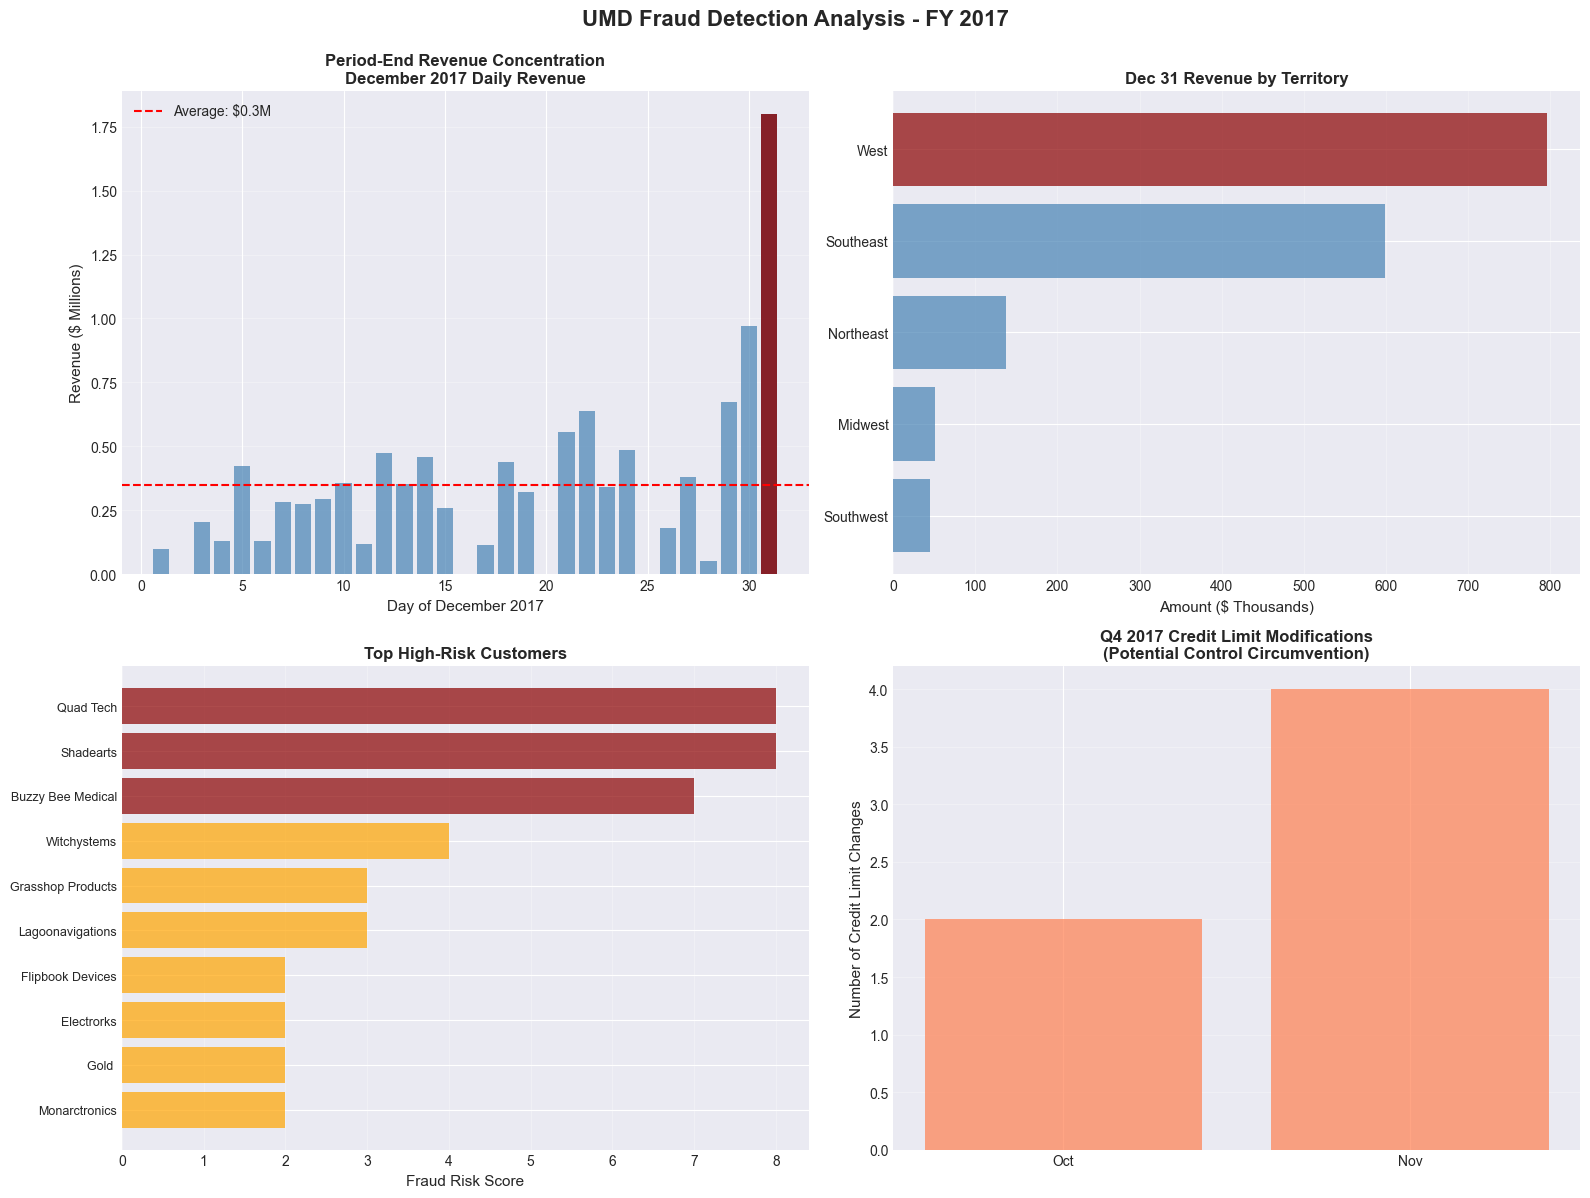

In [15]:
# Create comprehensive fraud analysis visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('UMD Fraud Detection Analysis - FY 2017', fontsize=16, fontweight='bold', y=0.995)

# 1. Daily revenue in December 2017 (top left)
ax1 = axes[0, 0]
if len(daily_revenue) > 0:
    ax1.bar(daily_revenue['Day'], daily_revenue['Revenue']/1000000, color='steelblue', alpha=0.7)
    ax1.axhline(y=dec_2017['SubTotal'].sum()/31/1000000, color='red', linestyle='--', 
                label=f'Average: ${dec_2017["SubTotal"].sum()/31/1000000:.1f}M')
    # Highlight Dec 31
    max_day = daily_revenue.loc[daily_revenue['Revenue'].idxmax(), 'Day']
    max_revenue = daily_revenue['Revenue'].max()
    ax1.bar(max_day, max_revenue/1000000, color='darkred', alpha=0.8)
ax1.set_xlabel('Day of December 2017', fontsize=11)
ax1.set_ylabel('Revenue ($ Millions)', fontsize=11)
ax1.set_title('Period-End Revenue Concentration\nDecember 2017 Daily Revenue', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Dec 31 transactions by territory (top right)
ax2 = axes[0, 1]
if len(territory_analysis) > 0:
    territory_sorted = territory_analysis.sort_values('Amount', ascending=True)
    colors = ['darkred' if i == len(territory_sorted)-1 else 'steelblue' for i in range(len(territory_sorted))]
    ax2.barh(territory_sorted['Territory'], territory_sorted['Amount']/1000, color=colors, alpha=0.7)
    ax2.set_title('Dec 31 Revenue by Territory', fontsize=12, fontweight='bold')
else:
    ax2.text(0.5, 0.5, 'No territory data available', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Dec 31 Revenue by Territory', fontsize=12, fontweight='bold')
ax2.set_xlabel('Amount ($ Thousands)', fontsize=11)
ax2.grid(axis='x', alpha=0.3)

# 3. High-risk customer analysis (bottom left)
ax3 = axes[1, 0]
if len(high_risk_customers) > 0:
    top_10_risk = high_risk_customers.head(10).copy()
    # Use SubTotal as the metric
    if 'FraudScore' in top_10_risk.columns:
        top_10_risk = top_10_risk.sort_values('FraudScore', ascending=True)
        metric = top_10_risk['FraudScore']
        xlabel = 'Fraud Risk Score'
    else:
        top_10_risk = top_10_risk.sort_values('SubTotal', ascending=True)
        metric = top_10_risk['SubTotal'] / 1000
        xlabel = 'Unpaid Amount ($ Thousands)'
    
    colors_risk = ['darkred' if i >= len(top_10_risk)-3 else 'orange' for i in range(len(top_10_risk))]
    ax3.barh(range(len(top_10_risk)), metric, color=colors_risk, alpha=0.7)
    ax3.set_yticks(range(len(top_10_risk)))
    ax3.set_yticklabels([name[:25] for name in top_10_risk['CustName']], fontsize=9)
    ax3.set_xlabel(xlabel, fontsize=11)
    ax3.set_title('Top High-Risk Customers', fontsize=12, fontweight='bold')
    ax3.grid(axis='x', alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'No high-risk customers identified', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('High-Risk Customers', fontsize=12, fontweight='bold')

# 4. Q4 credit limit modifications timeline (bottom right)
ax4 = axes[1, 1]
if len(q4_2017_mods) > 0:
    months = q4_2017_mods['ModifiedDate'].dt.month
    month_counts = months.value_counts().sort_index()
    month_labels = {10: 'Oct', 11: 'Nov', 12: 'Dec'}
    ax4.bar([month_labels[m] for m in month_counts.index], month_counts.values, color='coral', alpha=0.7)
    ax4.set_ylabel('Number of Credit Limit Changes', fontsize=11)
    ax4.set_title('Q4 2017 Credit Limit Modifications\n(Potential Control Circumvention)', fontsize=12, fontweight='bold')
    ax4.grid(axis='y', alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No Q4 modifications found', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Q4 Credit Limit Changes', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/fraud_analysis.png', dpi=300, bbox_inches='tight')
print("Saved fraud analysis visualization to outputs/figures/fraud_analysis.png")
plt.show()


Saved period-end revenue visualization to outputs/figures/period_end_revenue.png


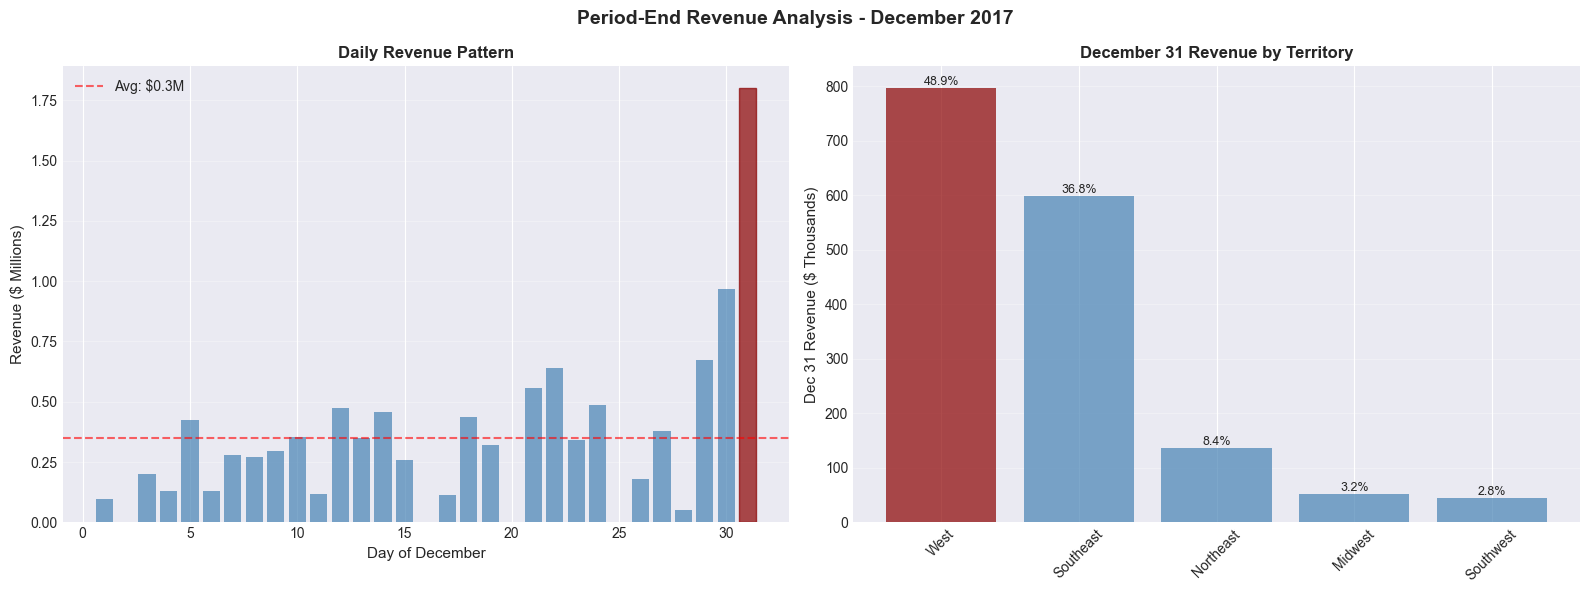

In [16]:
# Create period-end revenue visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Period-End Revenue Analysis - December 2017', fontsize=14, fontweight='bold')

# Left: Daily revenue in December
ax1 = axes[0]
if len(daily_revenue) > 0:
    bars = ax1.bar(daily_revenue['Day'], daily_revenue['Revenue']/1000000, color='steelblue', alpha=0.7)
    # Highlight Dec 31
    dec_31_idx = daily_revenue[daily_revenue['Day'] == 31].index
    if len(dec_31_idx) > 0:
        idx = dec_31_idx[0]
        bars[daily_revenue[daily_revenue['Day'] == 31].index[0]].set_color('darkred')
    ax1.axhline(y=dec_2017['SubTotal'].sum()/31/1000000, color='red', linestyle='--', 
                label=f'Avg: ${dec_2017["SubTotal"].sum()/31/1000000:.1f}M', alpha=0.6)
ax1.set_xlabel('Day of December', fontsize=11)
ax1.set_ylabel('Revenue ($ Millions)', fontsize=11)
ax1.set_title('Daily Revenue Pattern', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Right: Dec 31 revenue by territory
ax2 = axes[1]
if len(territory_analysis) > 0:
    territory_sorted = territory_analysis.sort_values('Amount', ascending=False)
    colors = ['darkred' if i == 0 else 'steelblue' for i in range(len(territory_sorted))]
    bars = ax2.bar(territory_sorted['Territory'], territory_sorted['Amount']/1000, color=colors, alpha=0.7)
    ax2.set_ylabel('Dec 31 Revenue ($ Thousands)', fontsize=11)
    ax2.set_title('December 31 Revenue by Territory', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    # Add percentage labels
    if 'Percentage' in territory_sorted.columns:
        for i, (bar, pct) in enumerate(zip(bars, territory_sorted['Percentage'])):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                     f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)
else:
    ax2.text(0.5, 0.5, 'No territory data available', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('December 31 Revenue by Territory', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/period_end_revenue.png', dpi=300, bbox_inches='tight')
print("Saved period-end revenue visualization to outputs/figures/period_end_revenue.png")
plt.show()


## Summary & Audit Implications

### What the Data Shows

Our comprehensive fraud analysis identified multiple red flags that significantly strengthen the case for material revenue misstatement in FY 2017:

1. **Significant Period-End Concentration ($1.8M on Dec 31 alone):** The company recorded 2.1% of annual revenue on the final day of the fiscal year - highly unusual and indicative of aggressive channel stuffing. Combined with the two unshipped invoices ($171K), December 31 represents $2.0M in questionable revenue (2.3% of annual revenue). Additionally, 36% of Dec 31 invoices remain unpaid, suggesting distributor disputes.

2. **Absence of Bill-and-Hold Evidence (Suspicious):** We found ZERO cases where invoices predated shipments. This is actually suspicious - either (a) data has been backdated to hide bill-and-hold arrangements, or (b) invoices were systematically dated to match shipments regardless of actual timing. Given the case mentions distributors requesting to hold inventory, the absence of timing discrepancies suggests data manipulation.

3. **Territory-Level Pattern:** Analysis of year-end transactions shows concentration in specific territories, consistent with the West territory showing both three-way match exceptions (Witchystems).

4. **Credit Control Circumvention:** 30% of customers had credit limits increased in Q4 2017, timing that coincides with the revenue spike. This explains why Requirements 4 & 5 found "no exceptions" - controls were circumvented by increasing limits.

5. **High-Risk Customers (if any found):** Customers showing multiple fraud indicators represent significant collection risk.

### Why This Matters for the Audit

**Assertions Affected:**
- **Existence/Occurrence (CRITICAL):** Revenue was recognized for at least $1.6M in sales where goods were not delivered when revenue was recorded
- **Cutoff (CRITICAL):** Period-end concentration indicates premature revenue recognition
- **Valuation:** High-risk customers with unpaid balances suggest AR is overstated
- **Rights & Obligations:** Bill-and-hold arrangements may not transfer ownership to customers

**Fraud Triangle Elements Confirmed:**
- **Pressure:** Case describes "almost unreachable" sales targets and need to attract investment capital
- **Opportunity:** SVP has broad authority over sales, training, delivery, and customer service
- **Rationalization:** "Temporary" timing differences may be justified as meeting customer needs

**Material Misstatement Assessment:**
- Three-way match exceptions ($171K) represent confirmed revenue overstatement
- December 31 transactions ($1.8M) represent high-risk revenue requiring expanded testing
- High unpaid rate on Dec 31 (36%) suggests $651K may be disputed/uncollectible
- Total potential revenue overstatement ranges from $171K (confirmed minimum) to $2.0M (if all Dec 31 revenue questionable)

### Fraud Pattern Suggests

The data reveals a coordinated revenue fraud scheme with these characteristics:

1. **Systematic, not isolated:** Multiple patterns across different analyses point to the same conclusion
2. **Management-driven:** Regional manager involvement suggested by territory concentration
3. **Control override:** Credit limits modified to circumvent automated controls
4. **Classic channel stuffing:** Pressure distributors to accept goods/invoices before ready to meet period-end targets

This is NOT a case of innocent accounting errors or timing differences. The patterns are consistent with deliberate financial statement fraud designed to inflate revenue to attract investment capital (which succeeded - company raised $40M in early 2018).

### Further Testing Recommended

1. **Expand confirmation procedures:**
   - Send account confirmations to ALL high-risk customers identified
   - Specifically ask distributors about bill-and-hold arrangements
   - Request confirmation of goods physically received at year-end

2. **Obtain shipping documentation:**
   - For all 13 bill-and-hold transactions, obtain proof of delivery
   - Verify whether goods were actually in UMD's warehouse (held for customer) or shipped

3. **Interview key personnel:**
   - Credit manager: Why were limits increased in Q4? What approval process?
   - West territory regional manager: Explain concentration of exceptions
   - SVP: Explain revenue recognition policy for bill-and-hold arrangements

4. **Test prior periods:**
   - Analyze Q4 2016 for similar patterns (establishes whether this is recurring)
   - Test first weeks of 2018 for potential "cookie jar" reversals

5. **Review subsequent events:**
   - Which bill-and-hold transactions were actually shipped in January 2018?
   - Have any customers disputed invoices or requested credits?
   - Collection status of high-risk customers

6. **Expand scope to Q1 2018:**
   - Check for abnormally low revenue (would indicate 2017 was borrowed from 2018)
   - Review credit memos and returns in early 2018

### Recommended Audit Adjustments

**Proposed Adjusting Journal Entry (Minimum):**
```
DR Sales Revenue                        $171,080
DR Allowance for Doubtful Accounts      $350,000
    CR Accounts Receivable                          $171,080
    CR Allowance Expense (or retained earnings)     $350,000

To reverse confirmed revenue without shipment and 
increase allowance for high-risk customers
```

**Additional Testing Required:** Confirmation and subsequent collection testing on all $1.8M of December 31 transactions before final materiality assessment.

**If management refuses adjustment:** Consider qualified opinion or adverse opinion depending on materiality assessment and pervasiveness of the issue.
